# Generate a top-n list of products to user from amazon Electronics Dataset

# Importing Librarires

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split as ttsplit
from surprise import SVD
from surprise import dataset
from surprise import Reader
%matplotlib inline

In [3]:
#Data Import
#Read and explore the dataset. ( Rename column, plot histograms, find data characteristics)
#Import the data set
data =pd.read_csv("ratings_Electronics.csv",names=['UserID','ProductID','Ratings','Timestamp'])

In [4]:
data.head()

,UserID,ProductID,Ratings,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
df=data.drop('Timestamp',axis=1)

In [6]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [7]:
#Check Data types
df.dtypes

UserID        object
ProductID     object
Ratings      float64
dtype: object

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 UserID       0
ProductID    0
Ratings      0
dtype: int64


There are no missing values with total records 7824482

In [9]:
df['Ratings'].unique()

array([5., 1., 3., 2., 4.])

In [11]:
# Summary statistics of 'rating' variable
df['Ratings'].describe().transpose().astype('int32')

count    7824482
mean           4
std            1
min            1
25%            3
50%            5
75%            5
max            5
Name: Ratings, dtype: int32

In [12]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['Ratings'].min()))
print('The maximum rating is: %d' %(df['Ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


Ratings are on scale of 1 - 5

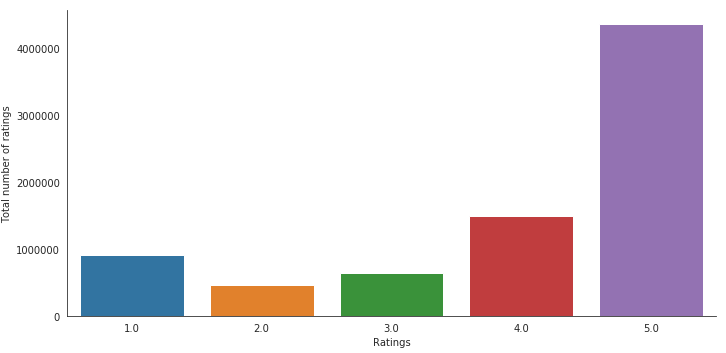

In [13]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserID'].nunique())
print('Number of unique PRODUCTS in Raw data = ', df['ProductID'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476002


Number of users are large approx. 10 times higher than the products number
Lets find distribution of number ratings by user and for a product

In [15]:
user=df.groupby('UserID').count()

Text(0.5, 0, 'Number of Ratings')

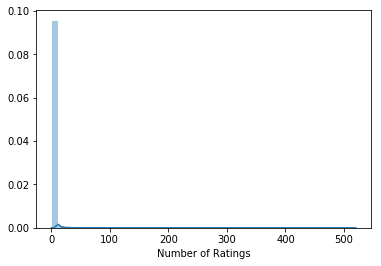

In [16]:
sns.distplot(user['Ratings'])
plt.xlabel('Number of Ratings')

In [17]:
user['Ratings'].describe().astype('int32')

count    4201696
mean           1
std            2
min            1
25%            1
50%            1
75%            2
max          520
Name: Ratings, dtype: int32

It shows 50% of people given rating only once and 75% given rating only 2 times. Data is very sparse and skewed. We can see that max number of ratings by a user is 520.
lets make it dense by choosing dataset of user who has given rating atleast for 50 products

Text(0.5, 0, 'Number of Ratings')

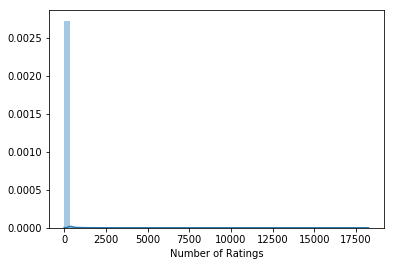

In [18]:
product=df.groupby('ProductID').count()
sns.distplot(product['Ratings'])
plt.xlabel('Number of Ratings')

In [19]:
product['Ratings'].describe().astype('int32')

count    476002
mean         16
std         112
min           1
25%           1
50%           2
75%           7
max       18244
Name: Ratings, dtype: int32

Wow a product as received 18244 ratings..
but in product distribution too the data is sparse

Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of 
ratings)

In [20]:
# Top 10 users based on rating
most_rated = df.groupby('UserID').size().sort_values(ascending=False)[:10]
most_rated

UserID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

Data model preparation as per requirement on number of minimum ratings

In [21]:
counts = df['UserID'].value_counts()
df_final = df[df['UserID'].isin(counts[counts >= 50].index)]

In [22]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserID'].nunique())
print('Number of unique PRODUCTS in final data = ', df_final['ProductID'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique PRODUCTS in final data =  48190


Number of products is 40 times more than number of user.Thus user-user collabrative filtering is preferred than item-item collabrative filtering

count    48190
mean         2
std          5
min          1
25%          1
50%          1
75%          2
max        206
Name: Ratings, dtype: int32

Text(0.5, 0, 'Number of Ratings')

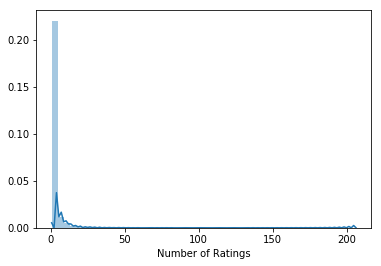

In [25]:
productf=df_final.groupby('ProductID').count()
sns.distplot(productf['Ratings'])
display(productf['Ratings'].describe().astype('int32'))
plt.xlabel('Number of Ratings')

Even Now data is skewed but less skewed than before

df_final has users who have rated 50 or more items

Calculate the density of the rating matrix

In [26]:
final_ratings_matrix = df_final.pivot(index = 'UserID', columns ='ProductID', values = 'Ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [27]:
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserID,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
ProductID,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=1)
train_data.head()

,UserID,ProductID,Ratings
4045824,AW63IRQWH10GF,B004DUMUA6,3.0
5461880,A2D1ZQEFS1NBH2,B006QDYH9U,1.0
1929770,AZNUHQSHZHSUE,B001DFZ5J2,4.0
685544,A3VTOLNB5N6FVP,B0009U7XH4,5.0
3461619,A17Z0LVY96TO53,B003MVZ60I,4.0


In [30]:
train_data.shape
test_data.shape

(37762, 3)

# Build Popularity Recommender model. (Non-personalised)

In [31]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped=pd.DataFrame({})
train_data_grouped['Mean_Ratings']=train_data.groupby('ProductID')['Ratings'].mean()
train_data_grouped['Usercount'] = train_data.groupby('ProductID')['Ratings'].count()
train_data_grouped.head()

,Mean_Ratings,Usercount
ProductID,,
0594451647,5.0,1
0970407998,2.5,2
0972683275,5.0,2
1400501466,3.0,2
1400501520,5.0,1


# 1) Pure Popularity based recommendation model(Based on Mean Ratings)

In [32]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['Mean_Ratings', 'Usercount'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['Mean_Ratings'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,Mean_Ratings,Usercount,Rank
ProductID,,,
0594451647,5.0,1,1.0
1400501520,5.0,1,2.0
1685560148,5.0,1,3.0
3744295508,5.0,1,4.0
8862935307,5.0,1,5.0


This is a problem as popularity method only sees the mean value of ratings. The products that rated as 5 even once takes top rating.
lets separate the data that has 5 ratings and sort by user count

In [33]:
train_data_grouped_5rating=train_data_grouped[train_data_grouped['Mean_Ratings']==5.0]
train_data_sort1 = train_data_grouped_5rating.sort_values('Usercount', ascending = False) 
      
#Generate a recommendation rank based upon score 
train_data_sort1['Rank'] = train_data_sort1['Usercount'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations1 = train_data_sort1.head(5) 
popularity_recommendations1[popularity_recommendations1['Rank']<6]

,Mean_Ratings,Usercount,Rank
ProductID,,,
B0052SCU8U,5.0,33,1.0
B0046TJG1U,5.0,17,2.0
B003MTTJOY,5.0,15,3.0
B000F7QRTG,5.0,14,4.0
B000IJY8DS,5.0,14,5.0


# 2) Popularity based on Number of users rated

In [34]:
train_data_sort2 = train_data_grouped.sort_values('Usercount', ascending = False) 
      
#Generate a recommendation rank based upon score 
train_data_sort2['Rank'] = train_data_sort2['Usercount'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations2 = train_data_sort2.head(5) 
popularity_recommendations2[popularity_recommendations2['Rank']<6]

,Mean_Ratings,Usercount,Rank
ProductID,,,
B0088CJT4U,4.174194,155,1.0
B003ES5ZUU,4.862903,124,2.0
B000N99BBC,4.803279,122,3.0
B007WTAJTO,4.758929,112,4.0
B00829TIEK,4.350000,100,5.0


Before splittig into train and test set in the df_final max number of user rating is 206 now 155.. it could be different or same product depending on the split

In [35]:
# Top 10 products based on number of rating
most_rated1 = df.groupby('ProductID').size().sort_values(ascending=False)[:10]
most_rated1

ProductID
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
dtype: int64

Above shows the difference between using full dataset and dense train set. The most rated products are different. lets take and proceed with dense set for this exercise.

Idealy it would make more sense to use full data set for popularity model as many new users could be buying a product. That product could be a need of the season,Could have been in sale for a very long time, could be a trend,could be new release hit.. etc..

# 3) Popularity based on Number of users rated and Mean Rating

In [36]:
train_data_grouped1=train_data_grouped.copy()
train_data_grouped1['count*ratings']=train_data_grouped['Mean_Ratings']*train_data_grouped['Usercount']
train_data_sort3 = train_data_grouped1.sort_values(['count*ratings'], ascending = False) 
      
#Generate a recommendation rank based upon score 
train_data_sort3['Rank'] = train_data_sort3['count*ratings'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations3 = train_data_sort3.head(5) 
popularity_recommendations3[popularity_recommendations3['Rank']<=5]

,Mean_Ratings,Usercount,count*ratings,Rank
ProductID,,,,
B0088CJT4U,4.174194,155,647.0,1.0
B003ES5ZUU,4.862903,124,603.0,2.0
B000N99BBC,4.803279,122,586.0,3.0
B007WTAJTO,4.758929,112,533.0,4.0
B004CLYEDC,4.709677,93,438.0,5.0


# Recommendations based on Pure Popularity Method

In [37]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations1 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols]
    rat=[]
    for i in  popularity_recommendations1.index:
        if sum((test_data['UserID']==user_id) & (test_data['ProductID']== i)):
            rat.append(test_data[(test_data['UserID']==user_id) & (test_data['ProductID']== i)].iloc[0,2])
        else:
            rat.append('Not Rated')
    user_recommendations['Actual_Rating']=rat 
          
    return user_recommendations 

In [38]:
find_recom = [test_data.iloc[1,0],test_data.iloc[10,0],test_data.iloc[25,0]]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    display(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A370XYLIZCSK1Y



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A370XYLIZCSK1Y,5.0,33,1.0,Not Rated
B0046TJG1U,A370XYLIZCSK1Y,5.0,17,2.0,Not Rated
B003MTTJOY,A370XYLIZCSK1Y,5.0,15,3.0,Not Rated
B000F7QRTG,A370XYLIZCSK1Y,5.0,14,4.0,Not Rated
B000IJY8DS,A370XYLIZCSK1Y,5.0,14,5.0,Not Rated




Here is the recommendation for the userId: AE88D7OM7YU99



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,AE88D7OM7YU99,5.0,33,1.0,Not Rated
B0046TJG1U,AE88D7OM7YU99,5.0,17,2.0,Not Rated
B003MTTJOY,AE88D7OM7YU99,5.0,15,3.0,Not Rated
B000F7QRTG,AE88D7OM7YU99,5.0,14,4.0,Not Rated
B000IJY8DS,AE88D7OM7YU99,5.0,14,5.0,Not Rated




Here is the recommendation for the userId: A2VALCFTOWFYXZ



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A2VALCFTOWFYXZ,5.0,33,1.0,Not Rated
B0046TJG1U,A2VALCFTOWFYXZ,5.0,17,2.0,Not Rated
B003MTTJOY,A2VALCFTOWFYXZ,5.0,15,3.0,Not Rated
B000F7QRTG,A2VALCFTOWFYXZ,5.0,14,4.0,Not Rated
B000IJY8DS,A2VALCFTOWFYXZ,5.0,14,5.0,Not Rated


Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user and based on only mean value of ratings

# Recommendations based on combining Popularity Methods

In [39]:
popularity_recommendations4=popularity_recommendations1.iloc[:3,:].drop('UserID',axis=1)
popularity_recommendations4=popularity_recommendations4.append(popularity_recommendations3.iloc[:1,:].drop('count*ratings',axis=1))
popularity_recommendations4=popularity_recommendations4.append(popularity_recommendations2.iloc[:1,:])
popularity_recommendations4['Rank']=[1,2,3,4,5]

In [40]:
# Use popularity based recommender model to make predictions
def recommend1(user_id):     
    user_recommendations = popularity_recommendations4
  
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols]
    rat=[]
    for i in  popularity_recommendations4.index:
        if sum((test_data['UserID']==user_id) & (test_data['ProductID']== i)):
            rat.append(test_data[(test_data['UserID']==user_id) & (test_data['ProductID']== i)].iloc[0,2])
        else:
            rat.append('Not Rated')
    user_recommendations['Actual_Rating']=rat    
    return user_recommendations 

In [41]:
find_recom = [test_data.iloc[1,0],test_data.iloc[10,0],test_data.iloc[25,0]]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    display(recommend1(i))    
    print("\n") 

Here is the recommendation for the userId: A370XYLIZCSK1Y



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A370XYLIZCSK1Y,5.000000,33,1,Not Rated
B0046TJG1U,A370XYLIZCSK1Y,5.000000,17,2,Not Rated
B003MTTJOY,A370XYLIZCSK1Y,5.000000,15,3,Not Rated
B0088CJT4U,A370XYLIZCSK1Y,4.174194,155,4,Not Rated
B0088CJT4U,A370XYLIZCSK1Y,4.174194,155,5,Not Rated




Here is the recommendation for the userId: AE88D7OM7YU99



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,AE88D7OM7YU99,5.000000,33,1,Not Rated
B0046TJG1U,AE88D7OM7YU99,5.000000,17,2,Not Rated
B003MTTJOY,AE88D7OM7YU99,5.000000,15,3,Not Rated
B0088CJT4U,AE88D7OM7YU99,4.174194,155,4,Not Rated
B0088CJT4U,AE88D7OM7YU99,4.174194,155,5,Not Rated




Here is the recommendation for the userId: A2VALCFTOWFYXZ



,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A2VALCFTOWFYXZ,5.000000,33,1,Not Rated
B0046TJG1U,A2VALCFTOWFYXZ,5.000000,17,2,Not Rated
B003MTTJOY,A2VALCFTOWFYXZ,5.000000,15,3,Not Rated
B0088CJT4U,A2VALCFTOWFYXZ,4.174194,155,4,Not Rated
B0088CJT4U,A2VALCFTOWFYXZ,4.174194,155,5,Not Rated


This is just a try to combine different ideas of popularity metric into a single model. Pure popularity method is based on only mean value as shown above. That will be used for further evaluation

# Evaluating the models Popularity model by RMSE

RMSE evaluation on test data is done as it is asked in project.

Discussed some alternate Evaluation: As popularity method shows same product to all the users. Unique users are taken from test data set and their ratings to the proposed model is used for evaluation... This method has a problem too, it fails to capture contribution of potential products that could be rated 5 by a user(for his taste) but not shown by the recommendation system as it is not popular.

And also discussed how many of the users in test data rated the popular products

Lets look at both evaluation

In [42]:
Test_groupby=pd.DataFrame({})
Test_groupby['ActualRatings']=test_data.groupby('ProductID')['Ratings'].mean()
Test_groupby.shape

(21466, 1)

In [43]:
Test_groupby['PredictedRatings']=train_data.groupby('ProductID')['Ratings'].mean()
print(Test_groupby.shape)
print('Number of missing values across columns-\n', Test_groupby.isnull().sum())

(21466, 2)
Number of missing values across columns-
 ActualRatings           0
PredictedRatings    10086
dtype: int64


This shows that almost half of the product were not in training set.

In [44]:
Test_groupby.fillna(0,inplace=True)
Test_groupby.head()

,ActualRatings,PredictedRatings
ProductID,,
0594481813,3.0,0.000000
0972683275,4.5,5.000000
1400501466,3.5,3.000000
1400532655,3.0,4.666667
1400599997,2.5,5.000000


In [45]:
RMSE = round(((((Test_groupby.ActualRatings - Test_groupby.PredictedRatings) ** 2).mean() )** 0.5), 5)
print('\nRMSE Popularity Model = {} \n'.format(RMSE))


RMSE Popularity Model = 3.07661 



RMSE is high for this method. As there are larger number of products not rated by users

In [46]:
test_data.head()

,UserID,ProductID,Ratings
1476088,A2CIQEY05SPHTZ,B000W9UYL4,2.0
3043226,A370XYLIZCSK1Y,B00347L6I6,5.0
3337660,ANTN61S4L7WG9,B003FMVPFY,5.0
2560304,A2HPJKM7L4EOQB,B002DW97WK,4.0
1725958,A1MRPX3RM48T2I,B0015HYPOO,4.0


In [47]:
Pure_recommend=recommend('i').index
df_test = test_data[test_data['ProductID'].isin(Pure_recommend)]

In [48]:
df_test.shape

(36, 3)

In [49]:
df_test.groupby('ProductID').count()

,UserID,Ratings
ProductID,,
B000F7QRTG,6,6
B000IJY8DS,3,3
B003MTTJOY,4,4
B0046TJG1U,7,7
B0052SCU8U,16,16


It shows our recommendation model would have been useful to only 36 people.

In [52]:
error=np.array(df_test['Ratings']-5)
print("RMSE for the only 36 users and 5 Products",np.sqrt((error**2).mean()))

RMSE for the only 36 users and 5 Products 0.44095855184409843


In [53]:
print('Number of unique USERS in test data = ', test_data['UserID'].nunique())

Number of unique USERS in test data =  1540


OF the 1540 users only 36 has rated the products proposed by the popularity method.
Taken it is a saturated data set taken for a long enough time we can say that our recommended products is not of interest to these people

In [54]:
print("Modified RMSE for the 1540 users and 5 Products",np.sqrt(((error**2).mean()+(1504*5/1504)**2))/2)

Modified RMSE for the 1540 users and 5 Products 2.509703391062599


# Build Collaborative Filtering 

Model-based Collaborative Filtering: Singular Value Decomposition

In [55]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = final_ratings_matrix.copy()
pivot_df.shape
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVD method with scipy (SVD : Method 1)

In [56]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [57]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns,index=pivot_df.index)
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
A100WO06OQR8BQ,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
A105S56ODHGJEK,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
A105TOJ6LTVMBG,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
A10AFVU66A79Y1,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [58]:
# Recommend the items with the highest predicted ratings
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
       
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.loc[userID]
    #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userID]
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['Actual_Rating', 'Predicted_Rating']    
    temp = temp.loc[temp.Actual_Rating == 0]   
    temp = temp.sort_values('Predicted_Rating', ascending=False)
    temp.replace({0:'Not Rated'},inplace=True)
    display(temp.head(num_recommendations))

In [59]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 'A100UD67AHFODS'
num_recommendations = 5
print('Below are the recommended items for user(user_id = {}):'.format(userID))
recommend_items(userID, pivot_df, preds_df, num_recommendations)

Below are the recommended items for user(user_id = A100UD67AHFODS):


,Actual_Rating,Predicted_Rating
Recommended Items,,
B003ES5ZUU,Not Rated,1.08766
B007WTAJTO,Not Rated,0.880925
B007OY5V68,Not Rated,0.663511
B00G4UQ6U8,Not Rated,0.634777
B002V88HFE,Not Rated,0.574183


Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on 
predictions made on the test data.)

Evaluation of Model-based Collaborative Filtering (SVD)

In [60]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [62]:
# Predicted ratings 
preds_df.head()

Recommended Items,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
A100WO06OQR8BQ,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
A105S56ODHGJEK,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
A105TOJ6LTVMBG,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
A10AFVU66A79Y1,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [63]:
# Average PREDICTED rating for each item
preds_df.mean().head()

Recommended Items
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [64]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [65]:
RMSE = round(((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() )** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will 
recommend 5 new products.

In [66]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 'A10AFVU66A79Y1'
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

,Actual_Rating,Predicted_Rating
Recommended Items,,
B0088CJT4U,Not Rated,0.902856
B000N99BBC,Not Rated,0.751
B00829TIEK,Not Rated,0.72355
B008DWCRQW,Not Rated,0.6578
B004CLYEDC,Not Rated,0.653919


# KNNwithmeans With Surprise Library

In [67]:
data=df_final.copy()

In [68]:
data.dtypes

UserID        object
ProductID     object
Ratings      float64
dtype: object

In [69]:
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

# Also, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df2, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df2['UserID'], df2['ProductID'], df2['Ratings'])]
        self.reader=reader

data1 = MyDataset(data, reader)

In [70]:
trainset, testset = ttsplit(data1, test_size=.3,random_state=2)

As already discussed number of products is more than number of users, so user-user collabrative filtering is performed. Performing item based filtering shows memory error

In [71]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [72]:
test_pred = algo.test(testset)
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0590


1.0590195029951641

In [73]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Top 5 Recommendations for all users in testdata

In [74]:
top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1CST2WUA32GP0 ['B005H3I38G', 'B000YTNZ8Q', 'B001AUBPL2', 'B001AU62GA', 'B006QZ7EKW']
A6FIAB28IS79 ['B00009RUCH', 'B0042F3K9W', 'B008AL9VXI', 'B000EMWBT2', 'B00006IAAN']
A27ADCSD15F3GL ['B003ES5ZSW', 'B0054L8N7M', 'B00829THK0', 'B007ZZ6OW6', 'B004XZHY34']
A200DY76VXVGP9 ['B001TH7GUK', 'B0052SCU8U', 'B001FA1NK0', 'B0034XRDUA', 'B001TH7GSW']
A2QRXQPHDMFCQV ['B005NHR6MU', 'B0044DEDB6', 'B00IM3OZ1C', 'B003M8I0RM', 'B0047AJ4I8']
ATDQ9CGCWTT8D ['B004X8EO6Q', 'B004WR125O', 'B007JOO4YS', 'B004D5GXOA', 'B0001XGQKY']
A2IT7S59GSASN7 ['B0002ZAILY', 'B002N56BKI', 'B0006GDC4O', 'B001G2YPYI', 'B003ES5ZUU']
A16CVJUQOB6GIB ['B004MNAFWY', 'B0002T85TW', 'B000092TR3', 'B00455M9AK', 'B005ISCE94']
ADKZOXAOV8EXD ['B004431UBM', 'B0026FCKC8', 'B004TI06TE', 'B0007W4IW2', 'B0017H4G0A']
A7QMQBGJ2TCQG ['B00009UTCD', 'B00005LEN4', 'B000VJX7DW', 'B000EOSHGQ', 'B0013A1XDE']
A2NJQF2UI60VGT ['B002RL875A', 'B0081FLFQE', 'B000FBK3QK', 'B004GF8TIK', 'B00BTCPQ5C']
A3AYSYSLHU26U9 ['B00EL8NIJC', 'B001FA1NZK', 'B00GDDQRH8', '

A1WUQF5HWBAQJU ['B00HIUL1JO', 'B009SGB3KI', 'B00JKO8QRG', 'B007KB0EGC', 'B00192KF12']
A3V2EZ6MA32FF6 ['B003GAMO6Y', 'B006DEBYWU', 'B001S2PPT0', 'B002HWRJY4', 'B0058NN6CS']
A18U49406IPPIJ ['B00H7PBWK8', 'B00JJJARWO', 'B0099TX7O4', 'B00HWT8I24', 'B00KIMX4EY']
A3QKIR8J56EUI1 ['B0015HS1HQ', 'B007RDAV02', 'B009WCZQTM', 'B004O6MN7E', 'B002C7481G']
A1VFX417XDNWIU ['B000092YQW', 'B0042X93AY', 'B001F0RPGG', 'B002QQ7TLY', 'B00829TIEK']
A16RI68PS6T5CA ['B0002TA96Y', 'B005D5M136', 'B00EO302SO', 'B001DJ7Y2O', 'B0099SMFVQ']
A4H4KYSM2KQ85 ['B0034CL2ZI', 'B002V8C3W2', 'B002BSH9SU', 'B00G4JZ2T0', 'B003O2S080']
AR74YY08IP2WE ['B009F7IBZK', 'B00FR6VL50', 'B000ZH7E5M', 'B00HR7FWUC', 'B001AG300A']
A20UU20K7M9ZPF ['B008F4H03S', 'B004EKEF0S', 'B002I32RE4', 'B0056EXUBQ', 'B005DUX5CM']
A19HT7YC1UW3D6 ['B003ZYF3M8', 'B000FBK3QK', 'B000HPV3RW', 'B001A4HAFS', 'B006JH8T3S']
A5KMMY627T3W ['B00BWHILCY', 'B003ZSHNGS', 'B00009UTLM', 'B009SYZ8OC', 'B001TODUXA']
A3NOBH42C7UI5M ['B00093IIRA', 'B00BOHNYTW', 'B005JACJ50', 

# Predicting RMSE for different models for comparision

In [75]:
from surprise import SlopeOne,NMF,NormalPredictor,KNNBaseline,KNNBasic,KNNWithZScore,BaselineOnly,CoClustering,SVDpp
from surprise.model_selection import cross_validate
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),KNNWithMeans(),KNNBaseline(),CoClustering(),KNNBasic(),KNNWithZScore()]:
    results = cross_validate(algorithm, data1, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.985056,7.338739,0.609352
KNNBaseline,1.046239,0.534866,1.456919
KNNWithMeans,1.065098,0.339740,1.160670
KNNWithZScore,1.069441,0.374321,1.216414
CoClustering,1.084956,8.993737,0.459306
KNNBasic,1.115047,0.190125,1.241815
NMF,1.147958,12.274356,0.550326


SVD model has low RMSE, but our previous SVD predictions and this is different

# SVD model using Surprise library (SVD :Method 2)

In [76]:
svd = SVD(n_factors=10,random_state=1)
svd.fit(trainset)
svdpre=svd.test(testset)
svdtop_n = get_top_n(svdpre, n=5)

In [77]:
def Rrecommend_items(test_data,dtop_n,Userid):
    RResults=pd.DataFrame({})
    recom=[]
    rat1=[]
    rat=[]
    for i in range(0,5):
        recom.append(dtop_n[Userid][i][0])
        rat1.append(dtop_n[Userid][i][1])
        if sum((test_data['UserID']==Userid) & (test_data['ProductID']==dtop_n[Userid][i][0])):
            rat.append(test_data[(test_data['UserID']==Userid) & (test_data['ProductID']==dtop_n[Userid][i][0])].iloc[0,2])
        else:
            rat.append('NotRated')    
    RResults['RecommendedProduct']=recom
    RResults['Predicted_Rating']=rat1
    RResults['Actual_Rating']=rat
    display(RResults)


In [78]:
print('SVD Recommendation for userid',test_data.iloc[1,0])
Rrecommend_items(test_data,svdtop_n,test_data.iloc[1,0])

SVD Recommendation for userid A370XYLIZCSK1Y


,RecommendedProduct,Predicted_Rating,Actual_Rating
0,B009NB8WR0,4.959274,5
1,B000IJY8DS,4.906157,NotRated
2,B008ALAHA4,4.848311,NotRated
3,B002FU5QMK,4.792324,5
4,B001QUA6R0,4.775473,NotRated


The actual rating being "NotRated" states that the item is yet to be rated by the user

# Recommendation for UserID in test data using different Models

# Test 1 : For test_data.iloc[1,0]   (UserID : 'A370XYLIZCSK1Y')

Popularity Based Recommendation

In [79]:
display(recommend(test_data.iloc[1,0]))       

,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A370XYLIZCSK1Y,5.0,33,1.0,Not Rated
B0046TJG1U,A370XYLIZCSK1Y,5.0,17,2.0,Not Rated
B003MTTJOY,A370XYLIZCSK1Y,5.0,15,3.0,Not Rated
B000F7QRTG,A370XYLIZCSK1Y,5.0,14,4.0,Not Rated
B000IJY8DS,A370XYLIZCSK1Y,5.0,14,5.0,Not Rated


Collabrative Filtering : SVD Recommendation

Method 1

In [80]:
recommend_items(test_data.iloc[1,0], pivot_df, preds_df, num_recommendations)

,Actual_Rating,Predicted_Rating
Recommended Items,,
B007WTAJTO,Not Rated,1.34214
B003ES5ZUU,Not Rated,1.15528
B002V88HFE,Not Rated,0.858505
B001TH7GUU,Not Rated,0.693718
B000QUUFRW,Not Rated,0.656278


Method 2

In [81]:
Rrecommend_items(test_data,svdtop_n,test_data.iloc[1,0])

,RecommendedProduct,Predicted_Rating,Actual_Rating
0,B009NB8WR0,4.959274,5
1,B000IJY8DS,4.906157,NotRated
2,B008ALAHA4,4.848311,NotRated
3,B002FU5QMK,4.792324,5
4,B001QUA6R0,4.775473,NotRated


Collabrative Filtering : KNNwithMeans Recommendation

In [82]:
Rrecommend_items(test_data,top_n,test_data.iloc[1,0])

,RecommendedProduct,Predicted_Rating,Actual_Rating
0,B008ALAHA4,5.000000,NotRated
1,B001QUA6R0,5.000000,NotRated
2,B0002QLDLC,5.000000,5
3,B002TLTGM6,4.940786,NotRated
4,B005KOZNBW,4.852841,NotRated


Few recommendations are same between KNNwithmeans and SVD method using surprise library

# Test 2 : For test_data.iloc[24,0]   

Popularity Based Recommendation

In [83]:
display(recommend(test_data.iloc[24,0]))       

,UserID,Mean_Ratings,Usercount,Rank,Actual_Rating
ProductID,,,,,
B0052SCU8U,A1Q5P5ML3176C0,5.0,33,1.0,Not Rated
B0046TJG1U,A1Q5P5ML3176C0,5.0,17,2.0,Not Rated
B003MTTJOY,A1Q5P5ML3176C0,5.0,15,3.0,Not Rated
B000F7QRTG,A1Q5P5ML3176C0,5.0,14,4.0,Not Rated
B000IJY8DS,A1Q5P5ML3176C0,5.0,14,5.0,Not Rated


Collabrative Filtering : SVD Recommendation

Method 1 :SVD

In [84]:
recommend_items(test_data.iloc[24,0], pivot_df, preds_df, num_recommendations)

,Actual_Rating,Predicted_Rating
Recommended Items,,
B007WTAJTO,Not Rated,0.395861
B003ES5ZUU,Not Rated,0.274149
B002V88HFE,Not Rated,0.181756
B005FYNSPK,Not Rated,0.167583
B002WE6D44,Not Rated,0.167141


Method 2 :SVD

In [85]:
Rrecommend_items(test_data,svdtop_n,test_data.iloc[24,0])

,RecommendedProduct,Predicted_Rating,Actual_Rating
0,B0016D1I0G,4.353520,5
1,B005GMRVZO,4.086374,NotRated
2,B006UMMPGE,4.041302,4
3,B00158QASW,4.039342,NotRated
4,B00009R6LS,4.039342,NotRated


Collabrative Filtering : KNNwithMeans Recommendation

In [86]:
Rrecommend_items(test_data,top_n,test_data.iloc[24,0])

,RecommendedProduct,Predicted_Rating,Actual_Rating
0,B00166EUI0,4.796914,5
1,B00158QASW,4.261301,NotRated
2,B00009R6LS,4.261301,NotRated
3,B005634RL4,4.261301,NotRated
4,B004F488Z6,4.261301,NotRated


No recommendations are same between KNNwithmeans and SVD method using surprise library

# Summarise your insights.

1) Popularity based recommendation system gives same recommendations to all the users

2) Pure Popularity based recommendations system is based on mean ratings. it doesnot take into account number of users rated      it.(in this data set)

3) Few modifications were done to the popularity recommendation system by taking into account number of user ratings and a        combined model is presented for recommendation.

4) RMSE evaluation metric is used for evaluation of popularity based model whose value is 3.07. Since same product is            recommended to all the users RMSE for that product alone predicted to be 2.509. The values is high as only 36 users out of    1540 in testet has rated the product

5) SVD Collaborative Filtering is a personalised recommender system, the recommendations are based on characteristics of 
   the user and product and RMSE is evaluated on test set
   
6) KNNWithmeans user-user collaborative Filtering is done and RMSE is evaluated on test set

7) Recommedations to a user based on popularity,SVD and KNNwithmeans model is discussed

8) SVD performed in two methods : 
    1) Taking the full dataset and recommending products the user has not bought
    2) Separating the dataset into test and train using surprise library and performing fit on train and predicting the test
 
9) Results of the SVD method 1 and 2 are completely different. Prediction ratings on method 1 is very low below 2. It may be     due to the fact that matrix is sparse(having large zeros) and the svds module is trying to match that zero using factors of     product and user. Zero rating does not mean that the user would rate zero to that product. It just means he has not rated it   yet. So the ratings by SVD method 1 is not the predicted rating for the user, but a potential trend in rating, showing us the   relative rating of product for ranking and recommending ( It is just my insight)

10) SVD method 2 using surprise library yields predictions close near potential actuals. Recommendations by this method and the     KNNwithmeans has some in common unlike SVD method 1

11) RMSE of different models were estimated and identified SVD to be the lowest of all
